In [180]:
import pandas as pd
import random
import csv

import numpy as np

import matplotlib.pyplot as plt
from pylab import rcParams

In [172]:
AIRPORT_ORIGIN = 27
TIME_ORIGIN = 1229231100

In [173]:
def get_infected_airports(df, p=1.e-6):
    times = []
    infected_airports = {AIRPORT_ORIGIN: TIME_ORIGIN - TIME_ORIGIN}
    for row in df.itertuples():
        _, id1, id2, time_start, time_stop, duration = row
        id1, id2 = int(id1), int(id2)
        times.append(int(time_start))
        time_start = int(time_start) - TIME_ORIGIN
        time_stop = int(time_stop) - TIME_ORIGIN

        if id1 in infected_airports and not id2 in infected_airports:
            if random.random() < p:
                infected_airports[id2] = time_stop
    #print(np.min(times))
    return infected_airports

In [192]:
df = pd.read_csv('events_US_air_traffic_GMT-1801-929483.txt', sep=' ')
df.sort_values(by = 'StartTime', inplace=True)
#SORT ALL THE FLIGHTS BY THEIR TIME
#ASSUME THE INFECTION STARTS AT THE AIRPORT WITH ID 27, WITH THE EARLIERST FLIGHT

In [193]:
TOTAL_AIRPORTS = 279

In [194]:
p_s = [0.01, 0.05, 0.1, 0.5, 1]
NTRIALS = 20

simulation = {}
for p in p_s:
    simulation[p] = []
    for i in range(NTRIALS):
        simulation[p].append(get_infected_airports(df, p))

In [197]:
num_infected = {}
for p in p_s:
    num_infected[p] = np.zeros(10)
    for trial in simulation[p]:
        for v in trial.values():
            for idx in range(len(num_infected[p])):
                if v < 12*(idx)*60*60:
                    num_infected[p][idx] += 1.0/NTRIALS/TOTAL_AIRPORTS
                    #overall scaling, that should be correct?

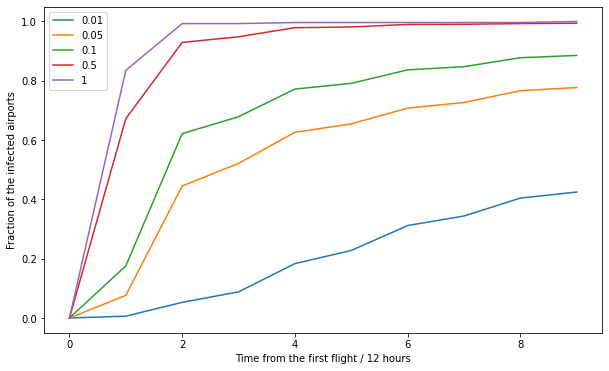

In [198]:
rcParams['figure.figsize'] = 10, 6
for p in p_s:
    plt.plot(num_infected[p], label=p)
plt.xlabel('Time from the first flight / 12 hours')
plt.ylabel('Fraction of the infected airports')
plt.legend()

In [199]:
#2nd part

In [201]:
NTRIALS_2 = 50
simulation_2 = []
p_2 = 0.5
for i in range(NTRIALS_2):
    simulation_2.append(get_infected_airports(df, p_2))

In [216]:
median_time = {} #id, time
for trial in simulation_2:
    for k, v in trial.items():
        if k in median_time:
            median_time[k].append(v)
        else:
            median_time[k] = []

In [217]:
median_time

{27: [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 16: [28560,
  39300,
  43980,
  39300,
  38880,
  28560,
  38880,
  39300,
  39300,
  28560,
  38940,
  30300,
  39840,
  39840,
  28560,
  28560,
  39300,
  28560,
  39840,
  39300,
  39300,
  38940,
  28560,
  28560,
  39300,
  28560,
  28560,
  28560,
  39840,
  39300,
  28560,
  39300,
  43980,
  42000,
  42240,
  28560,
  39300,
  39840,
  28560,
  28560,
  39300,
  39300,
  35700,
  28560,
  39300,
  39300,
  39840,
  39840,
  28560],
 7: [35400,
  23700,
  33300,
  28800,
  30900,
  31800,
  30900,
  28800,
  30900,
  31800,
  23700,
  23700,
  30900,
  23700,
  35400,
  33000,
  29400,
  31800,
  28800,
  28800,
  30900,
  28800,
  31560,
  35400,
  23700,
  31560,
  31260,
  31800,
  23700,
  23700,
  31800,
  23700,
  33300,
  31

In [218]:
median_times_ = {}
for k in median_time:
    inf_times = median_time[k]
    median_times_[k] = sum(inf_times)/len(inf_times)

In [219]:
median_times_

{27: 0.0,
 16: 35668.163265306124,
 7: 29621.632653061224,
 79: 30100.408163265307,
 15: 37884.489795918365,
 2: 27028.163265306124,
 72: 28866.122448979593,
 28: 29349.79591836735,
 4: 27328.163265306124,
 14: 31927.34693877551,
 80: 29042.448979591838,
 34: 31862.448979591838,
 89: 30821.632653061224,
 143: 35855.510204081635,
 26: 42205.71428571428,
 10: 29504.081632653062,
 32: 40602.857142857145,
 64: 28362.85714285714,
 83: 33704.08163265306,
 95: 31406.938775510203,
 109: 28201.224489795917,
 48: 28577.14285714286,
 84: 31515.918367346938,
 71: 30397.95918367347,
 24: 34211.02040816326,
 85: 30393.061224489797,
 50: 28424.081632653062,
 25: 40237.95918367347,
 46: 31793.877551020407,
 87: 29393.877551020407,
 75: 31427.755102040817,
 12: 30041.632653061224,
 77: 29511.428571428572,
 20: 28819.591836734693,
 65: 35624.08163265306,
 21: 30391.836734693876,
 19: 29369.38775510204,
 119: 30755.51020408163,
 163: 31784.081632653062,
 97: 30094.285714285714,
 141: 30080.816326530614,
